# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_val: ', (1000, 3, 32, 32))
('X_train: ', (49000, 3, 32, 32))
('X_test: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('y_train: ', (49000,))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76985004799e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.09081995087e-10
dw error:  2.17526355046e-10
db error:  7.73697883449e-12


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27563491363e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:

1. Sigmoid function suffers from the vanishing gradient problem because the gradient takes small values in the tails of the function (close to 0). A one dimensional example is to saturate the function, e.g., [-1e5,1e5]
2. ReLU's gradient is 0 or 1. Thus it can suffer from the vanishing gradient problem when all input values are negative. However, having all negative inputs is less probable. Because of this problem occurs only in one side (negative values), it is also known as the "dying ReLU problem", this name comes from the fact that some neurons will never be updated, i.e., they will be "dead". A one dimensional example that can vanish the gradient is to consider only negative values, e.g., [-1,-2,-4,-5].
3. Leaky ReLU tries to solve the ReLU problem of "dead" neurons by considering small negative slope when we have negative values, i.e., if x < 0 then alpha else x, where alpha can be equal to 0.01. A one dimensional example that can vanish the gradient is to consider all zero values, e.g., [0,0,0,0], it can only happen with a bad network initialization.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.39553504205e-11
dw error:  8.16201110576e-11
db error:  7.82672402146e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.9996027491
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.3025458445
dx error:  9.38467316199e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.17e-10
b1 relative error: 6.19e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 1.37e-07
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None
best_val = -1

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

for i in range(20):
    lr, reg, hidden_size = generate_random_hyperparams(-4,-2, -7, -4, 10, 200)
    model = TwoLayerNet(hidden_dim = hidden_size, reg= reg)
    cur_solver = Solver(model, data, update_rule='sgd', optim_config={'learning_rate':lr}, 
                        lr_decay=0.95, num_epochs=5,batch_size=200, print_every=-1, verbose=False)
    cur_solver.train()
    val_accuracy = cur_solver.best_val_acc
    if best_val < val_accuracy:
        best_val = val_accuracy
        solver = cur_solver
    # Print results
    print('lr %e reg %e hid %d  val accuracy: %f' % (
                lr, reg, hidden_size, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

lr 5.547653e-03 reg 7.123358e-07 hid 152  val accuracy: 0.213000
lr 3.304700e-04 reg 6.890565e-05 hid 126  val accuracy: 0.473000
lr 5.063610e-03 reg 1.486770e-07 hid 118  val accuracy: 0.215000
lr 1.794447e-04 reg 4.769166e-06 hid 38  val accuracy: 0.426000
lr 9.235702e-03 reg 1.392248e-06 hid 22  val accuracy: 0.140000
lr 3.801213e-04 reg 2.235742e-07 hid 76  val accuracy: 0.465000
lr 5.206455e-03 reg 3.586337e-07 hid 92  val accuracy: 0.190000
lr 1.061826e-04 reg 2.714656e-05 hid 88  val accuracy: 0.384000
lr 7.271861e-03 reg 7.792737e-06 hid 134  val accuracy: 0.155000
lr 5.377205e-04 reg 6.559638e-06 hid 56  val accuracy: 0.470000
lr 2.200057e-03 reg 4.408483e-07 hid 141  val accuracy: 0.496000
lr 5.204039e-03 reg 5.388462e-05 hid 86  val accuracy: 0.309000
lr 7.368653e-03 reg 7.769144e-05 hid 178  val accuracy: 0.131000
lr 6.771452e-04 reg 1.212714e-05 hid 88  val accuracy: 0.497000
lr 1.177248e-04 reg 1.992240e-05 hid 35  val accuracy: 0.364000
lr 2.015070e-04 reg 4.306539e-05 h

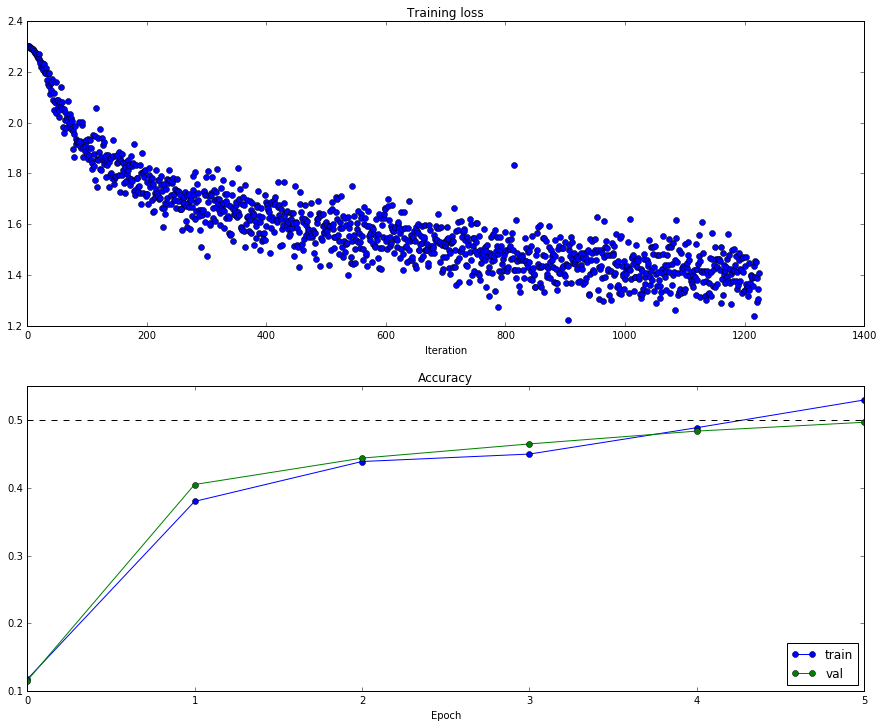

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30047908977
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.05211477653
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.604568
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.109000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.137000
(Epoch 2 / 20) train acc: 0.600000; val_acc: 0.155000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.170000
(Epoch 4 / 20) train acc: 0.800000; val_acc: 0.171000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.182000
(Iteration 11 / 40) loss: 0.402117
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.194000
(Epoch 7 / 20) train acc: 0.900000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.203000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.195000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.185000
(Iteration 21 / 40) loss: 0.245577
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.201000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.181000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.189000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.187000
(Iteration 31 / 40) loss: 

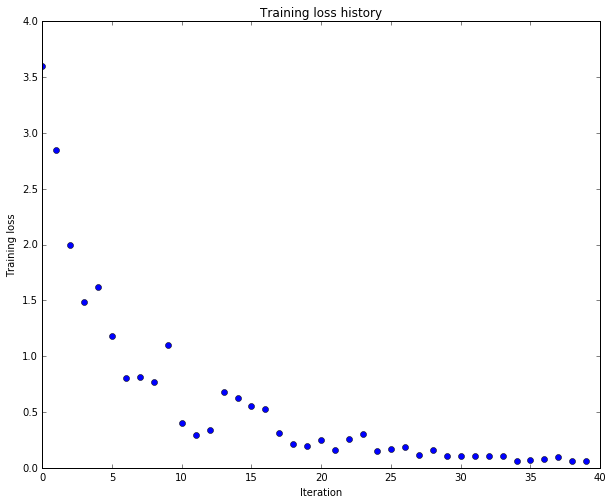

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# Obtained with random search
weight_scale = 2e-2
learning_rate = 3e-3

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 98.325850
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.082000
(Epoch 2 / 20) train acc: 0.300000; val_acc: 0.106000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.120000
(Epoch 4 / 20) train acc: 0.680000; val_acc: 0.123000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.137000
(Iteration 11 / 40) loss: 0.873759
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.129000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.127000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.133000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.129000
(Iteration 21 / 40) loss: 0.002604
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.131000
(Iteration 31 / 40) loss:

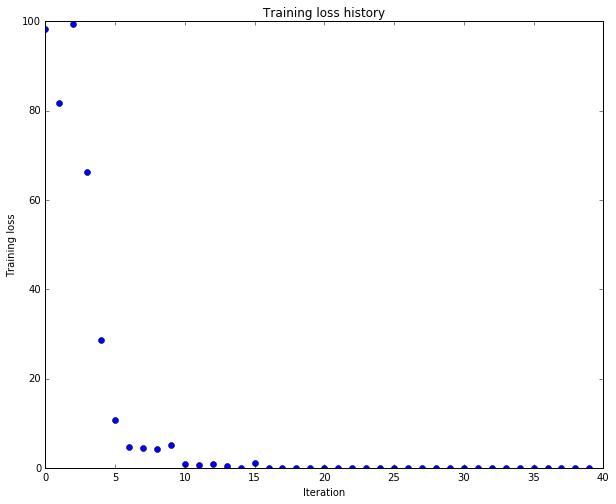

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# Obtained with random search
learning_rate = 2e-3
weight_scale = 9e-2

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:

Comparing the difficulty of training these two networks, the five layer net was more sensitive to the initialization scale. In my opinion, it is due to the number of layers. As we have a deeper network, setting a small scale leads to vanishing the gradients (small products), on the other hand a large scale leads to exploding the gradients (large products), in deeper networks it occurs more frequently than in shallow networks. Finding a correct scale is harder than the three-layer net but can be obtained by using random search. We can see this behaviour in the next example:

In [15]:
# Sensitivity to initialization scale
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

np.random.seed(1)
learning_rate = 1e-2
weight_scale = [1e-5, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1]

for we in weight_scale:
    model = FullyConnectedNet([100,100,100,100],
                    weight_scale=we, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=-1, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    }, verbose = False
             )
    solver.train()
    train_accuracy = solver.train_acc_history[len(solver.train_acc_history) - 1]
    print("learning_rate=%lf, weight_scale=%lf, train_accuracy=%lf" % (learning_rate, we, train_accuracy))
    for k,v in sorted(model.params.items()):
        if k[0] == 'W': #only print weights
            print("%s - mean=%lf, std=%lf" % (k, v.mean(), v.std()))
    print()

learning_rate=0.010000, weight_scale=0.000010, train_accuracy=0.160000
W1 - mean=0.000000, std=0.000010
W2 - mean=-0.000000, std=0.000010
W3 - mean=0.000000, std=0.000010
W4 - mean=0.000000, std=0.000010
W5 - mean=-0.000000, std=0.000010

learning_rate=0.010000, weight_scale=0.001000, train_accuracy=0.160000
W1 - mean=-0.000001, std=0.000999
W2 - mean=-0.000008, std=0.000997
W3 - mean=-0.000009, std=0.000999
W4 - mean=0.000014, std=0.000995
W5 - mean=0.000061, std=0.000975

learning_rate=0.010000, weight_scale=0.010000, train_accuracy=0.160000
W1 - mean=-0.000005, std=0.010000
W2 - mean=0.000012, std=0.009918
W3 - mean=0.000009, std=0.009958
W4 - mean=0.000079, std=0.009939
W5 - mean=0.000143, std=0.009803

learning_rate=0.010000, weight_scale=0.050000, train_accuracy=1.000000
W1 - mean=0.000027, std=0.049990
W2 - mean=-0.000561, std=0.049903
W3 - mean=0.000143, std=0.049845
W4 - mean=-0.000881, std=0.050095
W5 - mean=-0.000547, std=0.051637

learning_rate=0.010000, weight_scale=0.1000

As seen in the previous example, the mean and standard deviation of the parameters are close to zero when using a small weight scale (vanishing gradient), increasing the scale improves these values; however, increasing too much leads to large values (exploding gradient). When changing the size of hidden layers to two, this problem also arises. However, the weight scale is easier to find (1e-2), unlike the five layer network that requires a more specific weight scale (5e-2). Note that these weight scale values depend on the learning rate.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [16]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.492729
(Epoch 0 / 5) train acc: 0.132000; val_acc: 0.120000
(Iteration 11 / 200) loss: 2.219763
(Iteration 21 / 200) loss: 2.090585
(Iteration 31 / 200) loss: 2.085791
(Epoch 1 / 5) train acc: 0.286000; val_acc: 0.275000
(Iteration 41 / 200) loss: 2.023164
(Iteration 51 / 200) loss: 2.003168
(Iteration 61 / 200) loss: 1.932265
(Iteration 71 / 200) loss: 1.844771
(Epoch 2 / 5) train acc: 0.332000; val_acc: 0.298000
(Iteration 81 / 200) loss: 2.028104
(Iteration 91 / 200) loss: 1.756706
(Iteration 101 / 200) loss: 1.896209
(Iteration 111 / 200) loss: 1.862885
(Epoch 3 / 5) train acc: 0.392000; val_acc: 0.324000
(Iteration 121 / 200) loss: 1.668379
(Iteration 131 / 200) loss: 1.904703
(Iteration 141 / 200) loss: 1.786335
(Iteration 151 / 200) loss: 1.756344
(Epoch 4 / 5) train acc: 0.412000; val_acc: 0.344000
(Iteration 161 / 200) loss: 1.593084
(Iteration 171 / 200) loss: 1.626831
(Iteration 181 / 200) loss: 1.626227
(Iteration 191 / 200) los

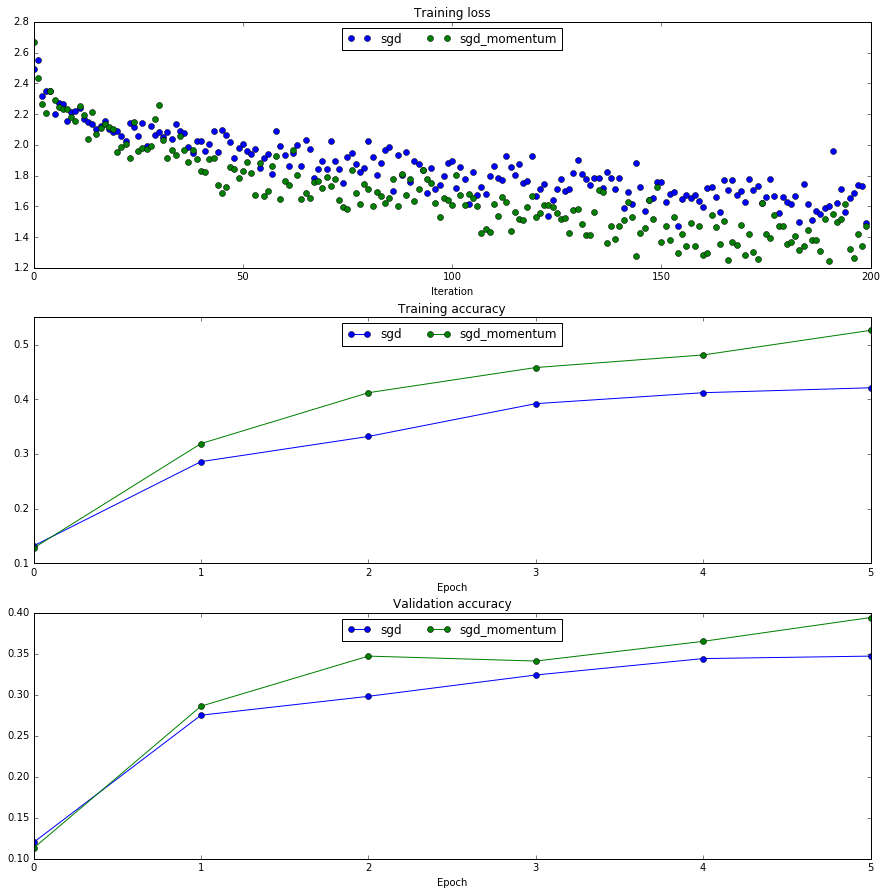

In [17]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [18]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [19]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 2.627778
(Epoch 0 / 5) train acc: 0.161000; val_acc: 0.142000
(Iteration 11 / 200) loss: 2.154819
(Iteration 21 / 200) loss: 2.031727
(Iteration 31 / 200) loss: 1.991367
(Epoch 1 / 5) train acc: 0.371000; val_acc: 0.325000
(Iteration 41 / 200) loss: 1.638600
(Iteration 51 / 200) loss: 1.692614
(Iteration 61 / 200) loss: 1.583546
(Iteration 71 / 200) loss: 1.720342
(Epoch 2 / 5) train acc: 0.455000; val_acc: 0.356000
(Iteration 81 / 200) loss: 1.595485
(Iteration 91 / 200) loss: 1.533544
(Iteration 101 / 200) loss: 1.658060
(Iteration 111 / 200) loss: 1.447045
(Epoch 3 / 5) train acc: 0.493000; val_acc: 0.371000
(Iteration 121 / 200) loss: 1.425781
(Iteration 131 / 200) loss: 1.261099
(Iteration 141 / 200) loss: 1.155655
(Iteration 151 / 200) loss: 1.350903
(Epoch 4 / 5) train acc: 0.575000; val_acc: 0.383000
(Iteration 161 / 200) loss: 1.178499
(Iteration 171 / 200) loss: 1.152615
(Iteration 181 / 200) loss: 1.178126
(Iteration 191 / 200) lo

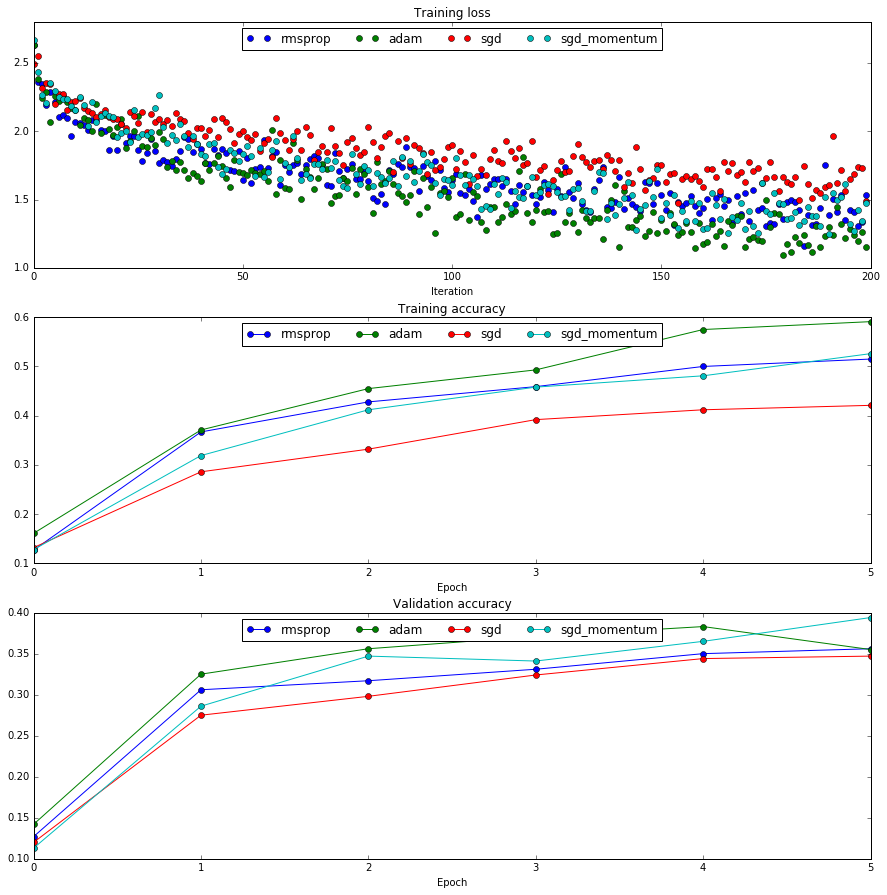

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:

The update becomes very small because at each iteration we are adding up the squared gradients. Thus, if the number of iterations is large then the cache value will be very large because we are accumulating positive values (cache += dw**2). Therefore, when dividing the gradient (dw) by the square root of the cache value (np.sqrt(cache)) the update will be very small. 

Adam does not have this issue because it uses an exponential weighted average (EWA) of the squared gradients (this part is based on RMSprop). That is, it accumulates past gradients weighted exponentially, assigning large weights to recent gradients and small weights to old gradients. Besides that, Adam uses EWA of momentum instead of the default gradient (dw), resulting in large updates controlled by the EWA of squared gradients.

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [21]:
best_model = None
best_val = -1
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# Random Search
for i in range(20):
    ws = 10**np.random.uniform(-2, -1)
    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-3, 3)
    model = FullyConnectedNet([100, 100], weight_scale=ws, reg= reg)

    solver = Solver(model, data,
                    num_epochs=10, batch_size=200,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr
                    },
                    verbose=False)
    solver.train()
    val_accuracy = solver.best_val_acc
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_model = model
    # Print results
    print('lr %e ws %e reg %e val accuracy: %f' % (
                lr, ws, reg, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.448683e-03 ws 2.612294e-02 reg 1.001581e-03 val accuracy: 0.504000
lr 8.084722e-04 ws 2.479182e-02 reg 1.508175e+00 val accuracy: 0.348000
lr 1.109170e-04 ws 2.074993e-02 reg 1.713368e-02 val accuracy: 0.513000
lr 2.784804e-03 ws 2.863913e-02 reg 6.072510e+01 val accuracy: 0.156000
lr 5.135145e-04 ws 4.758859e-02 reg 1.122726e-01 val accuracy: 0.466000
lr 2.590514e-05 ws 1.715123e-02 reg 2.183292e-02 val accuracy: 0.499000
lr 2.413797e-05 ws 3.128361e-02 reg 5.755838e-03 val accuracy: 0.428000
lr 7.345385e-04 ws 4.365774e-02 reg 1.282736e+01 val accuracy: 0.175000
lr 3.218354e-05 ws 3.837418e-02 reg 1.110231e-02 val accuracy: 0.376000
lr 1.057929e-04 ws 6.463707e-02 reg 1.923673e+00 val accuracy: 0.433000
lr 1.288630e-03 ws 4.543279e-02 reg 2.382235e+02 val accuracy: 0.112000
lr 1.271427e-05 ws 1.331773e-02 reg 7.343417e-01 val accuracy: 0.434000
lr 1.677979e-04 ws 2.627763e-02 reg 8.819529e+02 val accuracy: 0.107000
lr 7.965531e-04 ws 2.890517e-02 reg 2.561993e-03 val accuracy: 0

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [22]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.543
Test set accuracy:  0.555
